In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import numpy as np
from tqdm import tqdm
import os


In [2]:
dataset_path = 'NDD_DATASET'  # Replace with your dataset path
full_dataset = datasets.ImageFolder(
    root=dataset_path,
    transform=transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
)

In [3]:
# Calculate mean and std
loader = DataLoader(full_dataset, batch_size=64, shuffle=False, num_workers=2)
mean = 0.0
std = 0.0
for images, _ in tqdm(loader):
    batch_samples = images.size(0)  # batch size
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
    std += images.std(2).sum(0)

mean /= len(full_dataset)
std /= len(full_dataset)
print(f"Calculated Mean: {mean}, Std: {std}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 119/119 [00:10<00:00, 11.89it/s]

Calculated Mean: tensor([0.2163, 0.2163, 0.2163]), Std: tensor([0.2622, 0.2622, 0.2622])


In [4]:
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [5]:
full_dataset = datasets.ImageFolder(root=dataset_path, transform=data_transforms)


In [6]:
# Split dataset into train, validation, and test (80:10:10)
train_size = int(0.8 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

In [7]:
# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

In [8]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(401408, 1024),
        # 512 * 28 * 28 // (2**3)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 3)  # 3 classes
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = CNNModel()


In [9]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Early stopping parameters
patience = 3
best_val_loss = float('inf')
patience_counter = 0

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=401408, out_features=1024, bias=True)
    (2): ReLU()

In [10]:
best_model_path = "best_cnn1_model.pth"
num_epochs = 30

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Training phase
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train_samples = 0
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        train_correct += (predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    train_loss /= len(train_loader)
    train_accuracy = train_correct / total_train_samples * 100

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val_samples = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            total_val_samples += labels.size(0)

    val_loss /= len(val_loader)
    val_accuracy = val_correct / total_val_samples * 100

    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

    # Early stopping
    if val_loss < best_val_loss:
        print(f"Validation loss decreased ({best_val_loss:.4f} → {val_loss:.4f}). Saving model...")
        torch.save(model.state_dict(), best_model_path)
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        print(f"Patience Counter: {patience_counter}")

    if patience_counter >= patience:
        print("Early stopping triggered!")
        break


Epoch 1/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:13<00:00, 13.94it/s]


Train Loss: 0.5972, Train Accuracy: 68.89%
Val Loss: 0.4062, Val Accuracy: 80.90%
Validation loss decreased (inf → 0.4062). Saving model...
Epoch 2/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.40it/s]


Train Loss: 0.3954, Train Accuracy: 80.71%
Val Loss: 0.3382, Val Accuracy: 85.24%
Validation loss decreased (0.4062 → 0.3382). Saving model...
Epoch 3/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.04it/s]


Train Loss: 0.3365, Train Accuracy: 84.62%
Val Loss: 0.2943, Val Accuracy: 87.09%
Validation loss decreased (0.3382 → 0.2943). Saving model...
Epoch 4/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 14.94it/s]


Train Loss: 0.2976, Train Accuracy: 86.30%
Val Loss: 0.2645, Val Accuracy: 88.41%
Validation loss decreased (0.2943 → 0.2645). Saving model...
Epoch 5/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.21it/s]


Train Loss: 0.2610, Train Accuracy: 88.34%
Val Loss: 0.2495, Val Accuracy: 88.80%
Validation loss decreased (0.2645 → 0.2495). Saving model...
Epoch 6/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.08it/s]


Train Loss: 0.2157, Train Accuracy: 90.74%
Val Loss: 0.1804, Val Accuracy: 92.62%
Validation loss decreased (0.2495 → 0.1804). Saving model...
Epoch 7/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 14.95it/s]


Train Loss: 0.1689, Train Accuracy: 93.25%
Val Loss: 0.1460, Val Accuracy: 93.94%
Validation loss decreased (0.1804 → 0.1460). Saving model...
Epoch 8/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.39it/s]


Train Loss: 0.1220, Train Accuracy: 94.91%
Val Loss: 0.1308, Val Accuracy: 94.07%
Validation loss decreased (0.1460 → 0.1308). Saving model...
Epoch 9/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.28it/s]


Train Loss: 0.0880, Train Accuracy: 96.77%
Val Loss: 0.1176, Val Accuracy: 95.65%
Validation loss decreased (0.1308 → 0.1176). Saving model...
Epoch 10/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.23it/s]


Train Loss: 0.0589, Train Accuracy: 97.89%
Val Loss: 0.0681, Val Accuracy: 97.89%
Validation loss decreased (0.1176 → 0.0681). Saving model...
Epoch 11/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.08it/s]


Train Loss: 0.0346, Train Accuracy: 98.67%
Val Loss: 0.0506, Val Accuracy: 98.29%
Validation loss decreased (0.0681 → 0.0506). Saving model...
Epoch 12/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.02it/s]


Train Loss: 0.0275, Train Accuracy: 99.03%
Val Loss: 0.0468, Val Accuracy: 98.29%
Validation loss decreased (0.0506 → 0.0468). Saving model...
Epoch 13/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 14.88it/s]


Train Loss: 0.0246, Train Accuracy: 99.14%
Val Loss: 0.0490, Val Accuracy: 98.55%
Patience Counter: 1
Epoch 14/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.33it/s]


Train Loss: 0.0133, Train Accuracy: 99.54%
Val Loss: 0.0641, Val Accuracy: 98.29%
Patience Counter: 2
Epoch 15/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.12it/s]


Train Loss: 0.0095, Train Accuracy: 99.67%
Val Loss: 0.0430, Val Accuracy: 98.42%
Validation loss decreased (0.0468 → 0.0430). Saving model...
Epoch 16/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 14.99it/s]


Train Loss: 0.0109, Train Accuracy: 99.60%
Val Loss: 0.0414, Val Accuracy: 98.81%
Validation loss decreased (0.0430 → 0.0414). Saving model...
Epoch 17/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.33it/s]


Train Loss: 0.0105, Train Accuracy: 99.62%
Val Loss: 0.0803, Val Accuracy: 97.89%
Patience Counter: 1
Epoch 18/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.37it/s]


Train Loss: 0.0134, Train Accuracy: 99.60%
Val Loss: 0.0360, Val Accuracy: 98.95%
Validation loss decreased (0.0414 → 0.0360). Saving model...
Epoch 19/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.08it/s]


Train Loss: 0.0150, Train Accuracy: 99.42%
Val Loss: 0.0519, Val Accuracy: 98.02%
Patience Counter: 1
Epoch 20/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.32it/s]


Train Loss: 0.0064, Train Accuracy: 99.82%
Val Loss: 0.0383, Val Accuracy: 99.08%
Patience Counter: 2
Epoch 21/30


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 190/190 [00:12<00:00, 15.27it/s]


Train Loss: 0.0021, Train Accuracy: 99.92%
Val Loss: 0.0526, Val Accuracy: 98.68%
Patience Counter: 3
Early stopping triggered!


In [11]:
#Testing Phase

In [12]:
model.load_state_dict(torch.load('best_cnn1_model.pth'))
model.eval()

/tmp/ipykernel_2455091/1554558357.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_cnn1_model.pth'))


CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=401408, out_features=1024, bias=True)
    (2): ReLU()

In [13]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

In [14]:
# Initialize variables for metrics
test_loss = 0.0
test_correct = 0
total_test_samples = 0
all_labels = []
all_predictions = []

# Testing phase
with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Predictions and accuracy
        _, predicted = torch.max(outputs, 1)
        test_correct += (predicted == labels).sum().item()
        total_test_samples += labels.size(0)

        # Collect labels and predictions for metrics
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Calculate average test loss and accuracy
test_loss /= len(test_loader)
test_accuracy = test_correct / total_test_samples * 100

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.2f}%")


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 24/24 [00:01<00:00, 18.96it/s]

Test Loss: 0.0427
Test Accuracy: 98.82%



Classification Report:
              precision    recall  f1-score   support

  alzheimers       0.99      0.98      0.98       243
      normal       0.98      0.99      0.98       283
  parkinsons       1.00      1.00      1.00       234

    accuracy                           0.99       760
   macro avg       0.99      0.99      0.99       760
weighted avg       0.99      0.99      0.99       760


Confusion Matrix:
[[238   5   0]
 [  3 280   0]
 [  0   1 233]]


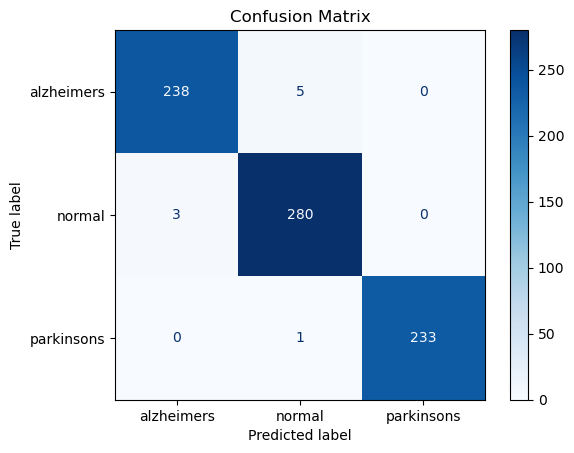

In [15]:
# Classification Report

print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=['alzheimers', 'normal', 'parkinsons']))

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("\nConfusion Matrix:")
print(conf_matrix)

# Plot Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['alzheimers', 'normal', 'parkinsons'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()